In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn import linear_model
from sklearn import svm
from sklearn import neural_network

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats import norm
from statistics import mean 

############################################
# House Price Auxiliary functions
############################################

# Get unique values per column
def print_unique_values_per_column(d):
    for c in d.columns:
        if (d[c].nunique() < 30):
            print(c, d[c].nunique(), d[c].dtype, d[c].unique())
        else:
            print(c, d[c].nunique(), d[c].dtype)

# Print missing values
def print_missing_values(d):
    missing_total = d.isnull().sum().sort_values(ascending=False)
    missing_percent = (d.isnull().sum()/d.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([missing_total, missing_percent], axis=1, keys=['Total', 'Percent'])
    missing = missing[missing['Percent'] > 0]
    print(missing)
    
def get_columns_with_nulls(d):
    missing_total = d.isnull().sum().sort_values(ascending=False)
    missing_percent = (d.isnull().sum()/d.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([missing_total, missing_percent], axis=1, keys=['Total', 'Percent'])
    missing = missing[missing['Percent'] > 0]
    return missing.index.values

# Custom accuracy evaluation
def accuracy_score(estimator, X, y):
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    accuracy = mean(1 - mean_absolute_error(y, y_pred)/y_pred)
    return accuracy

ModuleNotFoundError: No module named 'seaborn'

In [7]:
d = pd.read_csv('./dataset.csv')
#test = pd.read_csv('./test.csv')
d = d.drop('Id', axis=1)
d
#print(d.shape)
#print(d.describe())

(1460, 80)
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161

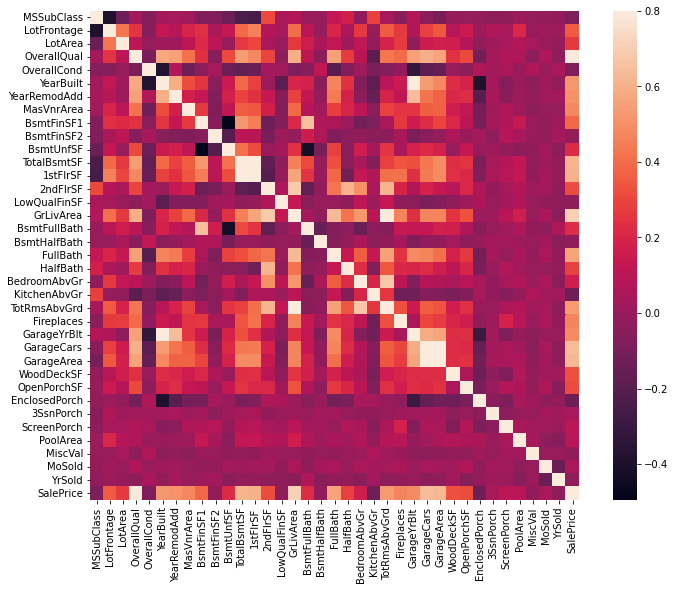

In [8]:
# Correlation matrix heat map
corrmat = d.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [9]:
print_missing_values(d)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageCond       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


10.122587643041712
11.719296021887518
10.979114687769968
12.72634673324568
12.011673342652106
11.341974195675187
11.387952205550924
10.659490508745975
10.949512317638483
10.772701811014713


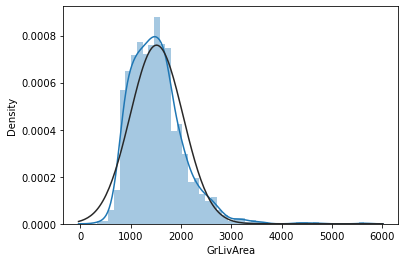

In [5]:
# Treat null values
d = d.drop('PoolQC', axis=1)
d = d.drop('MiscFeature', axis=1)
d = d.drop('Alley', axis=1)
d = d.drop('Fence', axis=1)
d = d.drop('FireplaceQu', axis=1)
d = d.drop('LotFrontage', axis=1)
d = d.drop(d[d['Electrical'].isnull()].index)

d = d.drop('KitchenAbvGr', axis=1)

"""
d = d.drop('GarageType', axis=1)
d = d.drop('GarageCond', axis=1)
d = d.drop('GarageFinish', axis=1)
d = d.drop('GarageQual', axis=1)
d = d.drop('GarageYrBlt', axis=1)
d = d.drop('BsmtFinType2', axis=1)
d = d.drop('BsmtExposure', axis=1)
d = d.drop('BsmtQual', axis=1)
d = d.drop('BsmtCond', axis=1)
d = d.drop('BsmtFinType1', axis=1)
d = d.drop('MasVnrArea', axis=1)
d = d.drop('MasVnrType', axis=1)
"""

# One hot encode
d = pd.get_dummies(d)

# Impute null values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
d = pd.DataFrame(imputer.fit_transform(d), columns=d.columns)

# Transformations
#sns.distplot(d['SalePrice'], fit=norm)
d['SalePrice'] = np.log(d['SalePrice'])

sns.distplot(d['GrLivArea'], fit=norm)
d['GrLivArea'] = np.log(d['GrLivArea'])



In [ ]:
# Undo the transformation for the output to get correct scores
y = np.exp(d['SalePrice'])
X = d.drop('SalePrice', axis=1)

r = linear_model.LinearRegression()
#r = svm.SVR(kernel='rbf')

# Get the results
#scores = cross_val_score(r, X, y, cv=2, scoring=accuracy_score)
#print(scores)

for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    r.fit(X_train, y_train)
    y_pred = r.predict(X_test)

    error = np.average((np.abs(y_test - y_pred) / y_test))
    print(error * 100)
